In [1]:
#pip install wfdb

In [2]:
#pip install torchmetrics

In [3]:
import torch

print(torch.cuda.is_available())
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

True


In [4]:
import pandas as pd
import numpy as np
import wfdb
import ast
import time

# ECG 데이터 로드 함수
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# 데이터 경로 설정
path = './'
sampling_rate=100

# ptbxl_database.csv 파일로부터 진단 정보 로드
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# 원본 신호 데이터 로드
X = load_raw_data(Y, sampling_rate, path)

# scp_statements.csv 파일로부터 진단 정보 집계를 위한 데이터 로드
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# 진단 정보를 집계하는 함수 정의
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# 진단 정보를 집계하여 대표 클래스로 변환하여 데이터프레임에 추가
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# 데이터를 학습용과 테스트용 으로 분할
#strat_fold = 10인 부분을 테스트 데이터로 사용
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [5]:
from sklearn.model_selection import train_test_split

# train data 중 25%를 validation data로 활용
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

#레이블을 원-핫 인코딩 형식으로 변환
mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train)
y_val_encoded = mlb.fit_transform(y_val)
y_test_encoded = mlb.transform(y_test)

print(y_train_encoded.shape)
print(y_val_encoded.shape)
print(y_test_encoded.shape)

(14725, 1000, 12)
(4909, 1000, 12)
(2203, 1000, 12)
(14725,)
(4909,)
(2203,)
(14725, 5)
(4909, 5)
(2203, 5)


In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
from torchmetrics import Accuracy

#데이터를 PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # (14725, 1000, 12)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)      # (4909, 1000, 12)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)    # (2203, 1000, 12)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

# 모델에 입력하기 위해 시계열 길이와 채널 수 조정
X_train_tensor = X_train_tensor.permute(0, 2, 1)  # (14725, 12, 1000)
X_val_tensor = X_val_tensor.permute(0, 2, 1)      # (4909, 12, 1000)
X_test_tensor = X_test_tensor.permute(0, 2, 1)    # (2203, 12, 1000)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_val_tensor.shape)
print(y_val_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([14725, 12, 1000])
torch.Size([14725, 5])
torch.Size([4909, 12, 1000])
torch.Size([4909, 5])
torch.Size([2203, 12, 1000])
torch.Size([2203, 5])


In [8]:
#pip install fastai

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# fast.ai 라이브러리 사용
from fastai.layers import *
from fastai.core import *

class AdaptiveConcatPoolRNN(nn.Module):
    def __init__(self, bidirectional):
        super().__init__()
        self.bidirectional = bidirectional # bidirectional을 사용할 것인지 선택
    def forward(self,x):
        #input shape bs, ch, ts
        # adaptive average pooling과 adaprive max pooling 사용하여 데이터 요약 및 정보 추출
        t1 = nn.AdaptiveAvgPool1d(1)(x)
        t2 = nn.AdaptiveMaxPool1d(1)(x)
        
        if(self.bidirectional is False):
            t3 = x[:,:,-1]
        else:
            channels = x.size()[1]
            t3 = torch.cat([x[:,:channels,-1],x[:,channels:,0]],1)
        out=torch.cat([t1.squeeze(-1),t2.squeeze(-1),t3],1) #output shape bs, 3*ch
        return out

class RNN1d(nn.Sequential):
    def __init__(self, input_channels, num_classes, lstm=True, hidden_dim=64, num_layers=2, bidirectional=False, ps_head=0.5, 
                 act_head="relu", lin_ftrs_head=None, bn=True):
        layers_tmp = []
        # bs, ch, ts -> ts, bs, ch
        layers_tmp.append(Lambda(lambda x: x.transpose(1, 2)))
        layers_tmp.append(Lambda(lambda x: x.transpose(0, 1)))
        # LSTM과 GRU중 선택
        if lstm:
            layers_tmp.append(nn.LSTM(input_size=input_channels, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=bidirectional))
        else:
            layers_tmp.append(nn.GRU(input_size=input_channels, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=bidirectional))
        # pooling
        layers_tmp.append(Lambda(lambda x: x[0].transpose(0, 1)))
        layers_tmp.append(Lambda(lambda x: x.transpose(1, 2)))

        layers_head = []

        layers_head.append(AdaptiveConcatPoolRNN(bidirectional))

        # classifier
        nf = 3 * hidden_dim if bidirectional is False else 6 * hidden_dim
        lin_ftrs_head = [nf, 128, 256, 128, 64, num_classes] if lin_ftrs_head is None else [nf] + lin_ftrs_head + [num_classes]
        ps_head = [0.5] * (len(lin_ftrs_head) - 2) + [ps_head]
        actns = [nn.ReLU(inplace=True) if act_head == "relu" else nn.ELU(inplace=True)] * (len(lin_ftrs_head) - 2) + [None]

        for ni, no, p, actn in zip(lin_ftrs_head[:-1], lin_ftrs_head[1:], ps_head, actns):
            layers_head += bn_drop_lin(ni, no, bn, p, actn)
        layers_head = nn.Sequential(*layers_head)
        layers_tmp.append(layers_head)

        super().__init__(*layers_tmp)
    
    def get_layer_groups(self):
        return (self[-1],)
    
    def get_output_layer(self):
        return self[-1][-1]
    
    def set_output_layer(self,x):
        self[-1][-1] = x

In [10]:
# 모델 생성
input_channels = 12  # 입력 데이터의 채널 수
num_classes = 5     # 클래스 수, STTC, MI, HYP, NORM ,CD의 총 다섯개 클래스

model = RNN1d(input_channels, num_classes, bidirectional=True, act_head="ELU").to(device)
print(model)



# Loss function과 optimizer
criterion = nn.BCEWithLogitsLoss()  # 다중 레이블 분류를 위한 BCEWithLogitsLoss
optimizer = optim.AdamW(model.parameters(), lr=0.005) # AdamW optimizer

def accuracy(predictions, labels):
    # Convert probabilities to binary predictions (0 or 1)
    binary_predictions = (predictions >= 0.5).to(torch.float32)
    
    # Compare binary predictions to the ground truth labels
    correct_predictions = (binary_predictions == labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct_predictions / labels.numel()
    
    return accuracy

# 학습 함수 정의
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)  # X_train_tensor의 shape을 (batch_size, feature_dim, sequence_length)로 확장
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy = accuracy(torch.sigmoid(outputs), y_train_tensor)

        # Validation loss 계산
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)  # X_val_tensor의 shape을 (batch_size, feature_dim, sequence_length)로 확장
            val_loss = criterion(val_outputs, y_val_tensor)
            val_accuracy = accuracy(torch.sigmoid(val_outputs), y_val_tensor)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# 모델 학습
num_epochs = 120
start_time = time.time()
train_model(model, criterion, optimizer, num_epochs)
end_time = time.time()
execution_time = end_time - start_time
print(f"It took {execution_time} seconds to run")

# 테스트 데이터로 평가
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # X_test_tensor의 shape을 (batch_size, feature_dim, sequence_length)로 확장
    test_preds = torch.sigmoid(test_outputs)  # 확률값으로 변환
    test_binary_preds = (test_preds >= 0.5).to(torch.float32)  # threshold를 기준으로 이진 클래스로 변환

y_test_binary = y_test_tensor.round()

test_accuracy = accuracy(test_binary_preds, y_test_tensor)
print(f"Test Accuracy: {test_accuracy:.4f}")


RNN1d(
  (0): Lambda()
  (1): Lambda()
  (2): LSTM(12, 64, num_layers=2, bidirectional=True)
  (3): Lambda()
  (4): Lambda()
  (5): Sequential(
    (0): AdaptiveConcatPoolRNN()
    (1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=384, out_features=128, bias=True)
    (4): ELU(alpha=1.0, inplace=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=128, out_features=256, bias=True)
    (8): ELU(alpha=1.0, inplace=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=256, out_features=128, bias=True)
    (12): ELU(alpha=1.0, inplace=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.5, inplace=False)
  

STTC: ROC AUC = 0.8914
NORM: ROC AUC = 0.8539
MI: ROC AUC = 0.9086
HYP: ROC AUC = 0.9430
CD: ROC AUC = 0.9143


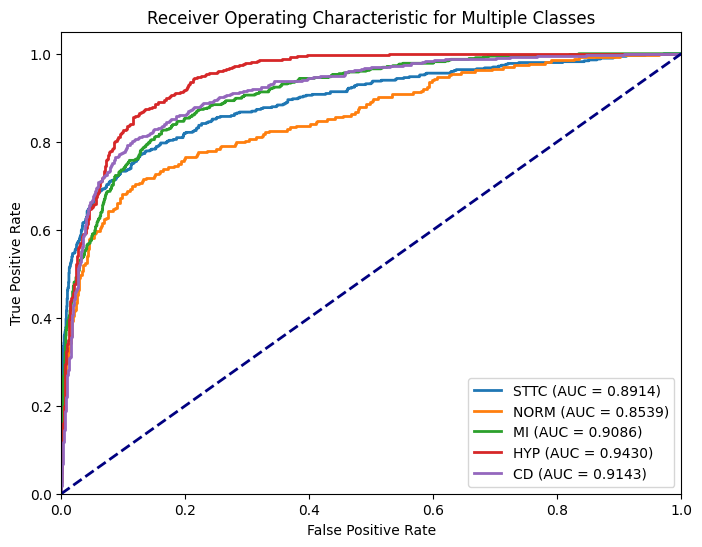

Graphs plotted.


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 각 클래스별 ROC AUC 평가 함수
def calculate_roc_auc(outputs, targets):
    roc_auc_scores = []
    fpr_list = []
    tpr_list = []
    for i in range(outputs.shape[1]):
        roc_auc = roc_auc_score(targets[:, i], outputs[:, i])
        fpr, tpr, _ = roc_curve(targets[:, i], outputs[:, i])
        roc_auc_scores.append(roc_auc)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    return roc_auc_scores, fpr_list, tpr_list

test_roc_auc_scores, fpr_list, tpr_list = calculate_roc_auc(test_outputs.cpu().numpy(), y_test_binary.cpu().numpy())

# 각 클래스별로 ROC AUC score 출력
for i, score in enumerate(test_roc_auc_scores):
    class_name = ['STTC', 'NORM', 'MI', 'HYP', 'CD']
    print(f"{class_name[i]}: ROC AUC = {score:.4f}")

# plt를 이용해 그래프에 클래스별 ROC Curve 출력
plt.figure(figsize=(8, 6))
for i, score in enumerate(test_roc_auc_scores):
    class_name = ['STTC', 'NORM', 'MI', 'HYP', 'CD']
    plt.plot(fpr_list[i], tpr_list[i], lw=2, label=f'{class_name[i]} (AUC = {score:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiple Classes')
plt.legend(loc="lower right")
plt.show()

print("Graphs plotted.")